### This notebook contains both the Scratch implementation and Pytorch implementation

In [23]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split·
from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset=pd.read_csv('dataset.csv')

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [35]:
top5 = dataset['PatientId'].value_counts().head(1000)
print(top5)

PatientId
8.221459e+14    88
9.963767e+10    84
2.688613e+13    70
3.353478e+13    65
8.713749e+14    62
                ..
8.216977e+11     6
2.965144e+12     6
7.925227e+13     6
4.238333e+13     6
6.911444e+13     6
Name: count, Length: 1000, dtype: int64


In [12]:
dataset['ScheduledDay'] = pd.to_datetime(dataset['ScheduledDay'])
dataset['AppointmentDay'] = pd.to_datetime(dataset['AppointmentDay'])

In [13]:
dataset['No-show']=dataset['No-show'].map({'Yes':1,'No':0})
dataset['Gender'] = dataset['Gender'].map({'M': 1, 'F': 0})


dataset['ScheduledDay'] = pd.to_datetime(dataset['ScheduledDay'])

dataset['AppointmentDay'] = pd.to_datetime(dataset['AppointmentDay'])
dataset['ScheduledHour'] = dataset['ScheduledDay'].dt.hour
dataset['AppointmentHour'] = dataset['AppointmentDay'].dt.hour

dataset['AppointmentWeekday'] = dataset['AppointmentDay'].dt.dayofweek
dataset['DaysWaited'] = (dataset['AppointmentDay'].dt.normalize() - dataset['ScheduledDay'].dt.normalize()).dt.days

dataset=pd.get_dummies(dataset,columns=['AppointmentWeekday','Neighbourhood'])

dataset=dataset.drop(['PatientId','AppointmentID','AppointmentDay','ScheduledDay'],axis=1)

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 100 columns):
 #   Column                                     Non-Null Count   Dtype
---  ------                                     --------------   -----
 0   Gender                                     110527 non-null  int64
 1   Age                                        110527 non-null  int64
 2   Scholarship                                110527 non-null  int64
 3   Hipertension                               110527 non-null  int64
 4   Diabetes                                   110527 non-null  int64
 5   Alcoholism                                 110527 non-null  int64
 6   Handcap                                    110527 non-null  int64
 7   SMS_received                               110527 non-null  int64
 8   No-show                                    110527 non-null  int64
 9   PastAppointments                           110527 non-null  int64
 10  ScheduledHour                  

In [15]:
labels = dataset['No-show']
features = dataset.drop('No-show', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Data processing is done. Now, we will use the same transformed data for both models.

**First:** Scratch Model

Epoch: 004/200 | Train loss: 0.479 | Train F1:0.40| Train Acc: 65.37% | Valid Acc: 65.43%| Valid F1:0.40
Epoch: 008/200 | Train loss: 0.475 | Train F1:0.41| Train Acc: 66.30% | Valid Acc: 66.38%| Valid F1:0.41
Epoch: 012/200 | Train loss: 0.472 | Train F1:0.41| Train Acc: 65.69% | Valid Acc: 65.59%| Valid F1:0.41
Epoch: 016/200 | Train loss: 0.469 | Train F1:0.42| Train Acc: 65.29% | Valid Acc: 65.19%| Valid F1:0.42
Epoch: 020/200 | Train loss: 0.468 | Train F1:0.43| Train Acc: 62.61% | Valid Acc: 62.12%| Valid F1:0.42
Epoch: 024/200 | Train loss: 0.466 | Train F1:0.43| Train Acc: 66.13% | Valid Acc: 65.55%| Valid F1:0.42
Epoch: 028/200 | Train loss: 0.464 | Train F1:0.43| Train Acc: 65.32% | Valid Acc: 64.45%| Valid F1:0.42
Epoch: 032/200 | Train loss: 0.463 | Train F1:0.43| Train Acc: 66.49% | Valid Acc: 65.86%| Valid F1:0.42
Epoch: 036/200 | Train loss: 0.461 | Train F1:0.43| Train Acc: 65.34% | Valid Acc: 64.72%| Valid F1:0.43
Epoch: 040/200 | Train loss: 0.460 | Train F1:0.44| Tra

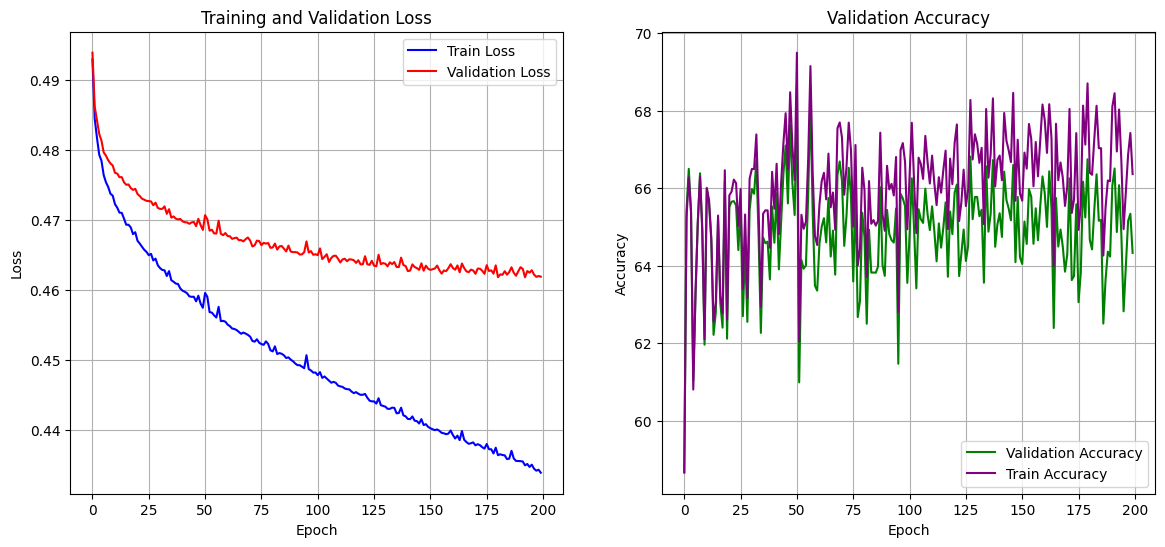

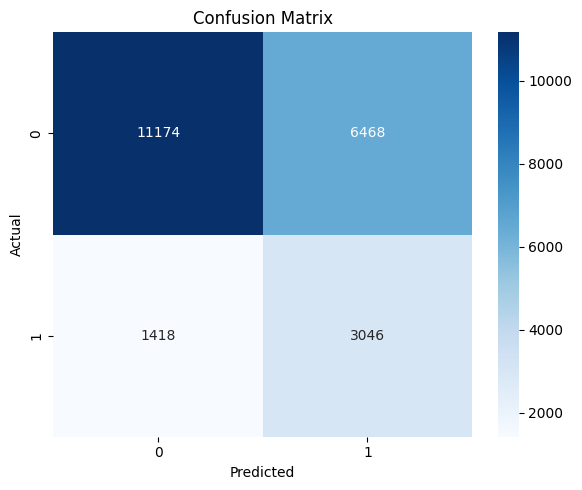


THRESHOLD OPTIMIZATION
Threshold | Precision | Recall | F1 Score 
----------------------------------------
0.10      | 0.262     | 0.905  | 0.406 
0.15      | 0.297     | 0.795  | 0.433 
0.20      | 0.320     | 0.682  | 0.436 
0.25      | 0.341     | 0.564  | 0.425 
0.30      | 0.363     | 0.445  | 0.400 
0.35      | 0.388     | 0.334  | 0.359 
0.40      | 0.403     | 0.230  | 0.293 
0.45      | 0.426     | 0.150  | 0.222 
0.50      | 0.457     | 0.093  | 0.155 
0.55      | 0.471     | 0.051  | 0.093 
0.60      | 0.483     | 0.029  | 0.055 
0.65      | 0.508     | 0.014  | 0.027 
0.70      | 0.537     | 0.008  | 0.016 
0.75      | 0.611     | 0.005  | 0.010 
0.80      | 0.571     | 0.003  | 0.005 
0.85      | 0.400     | 0.001  | 0.002 

Best threshold: 0.20 with F1 score: 0.4358


In [ ]:
from scratch import *

model=NeuralNet(num_classes=2,num_features=X_train_scaled.shape[1],num_hidden=256)

start=time.time()

train_loss,validation_loss, epoch_train_acc, epoch_valid_acc=train(model,X_train_scaled,y_train.values,
                                                        X_test_scaled,y_test.values,num_epochs=200,minibatch_size=64,learning_rate=0.003)
end=time.time()

print("Time taken:"+ f"{end - start:.4f}" +"seconds")
f1,precision,recall,pred_labels,PR_AUC= final_metrics(model,X_test_scaled,y_test.values,threshold=0.2)

print(f"Final Test Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"PR-AUC:    {PR_AUC:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report( y_test.values,pred_labels))


fig,axs=plt.subplots(1,2,figsize=(14, 6))

axs[0].plot(train_loss,label='Train Loss',color='blue')
axs[0].plot(validation_loss,label='Validation Loss',color='red')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(epoch_valid_acc, label='Validation Accuracy', color='green')
axs[1].plot(epoch_train_acc, label='Train Accuracy', color='purple')
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

cm = confusion_matrix(y_test.values,pred_labels )

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("THRESHOLD OPTIMIZATION")
print("="*50)

thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold=0.
best_f1=0

print("Threshold | Precision | Recall | F1 Score ")
print("-" * 40)
for threshold in thresholds:
    f1_t,precision_t,recall_t,_,PR_AUC= final_metrics(model,X_test_scaled,y_test.values,threshold=threshold)
    if(f1>best_f1):
        best_threshold=threshold
        best_f1=f1_t
    print(f"{threshold:.2f}      | {precision_t:.3f}     | {recall_t:.3f}  | {f1_t:.3f} ")

print(f"\nBest threshold: {best_threshold:.2f} with F1 score: {best_f1:.4f}")


**Second:** PyTorch Model

In [26]:
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,num_workers=2)


In [27]:
class NN(nn.Module):
    def __init__(self, input_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.out = nn.Linear(64,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.out(x)

torch_model = NN(input_size=X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(torch_model.parameters(), lr=0.002)

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate_epoch(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            total_loss += loss.item()

            probs = torch.sigmoid(output).view(-1)
            preds = (probs > 0.2).int().view(-1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.view(-1).cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = sum([p == t for p, t in zip(all_preds, all_labels)]) / len(all_labels)
    f1 = f1_score(all_labels, all_preds)

    return avg_loss, accuracy, f1, all_preds, all_labels,all_probs

Epoch   1 | Train Loss: 0.4323 | Val Loss: 0.4942 | Val Acc: 0.6258 | Val F1: 0.4468
Epoch  11 | Train Loss: 0.4280 | Val Loss: 0.5128 | Val Acc: 0.6444 | Val F1: 0.4472
Time taken : 22.070895671844482

FINAL EVALUATION ON TEST SET
Final Test Metrics:
Accuracy:  0.6444
Precision: 0.3259
Recall:    0.7124
F1 Score:  0.4472
PR-AUC:    0.3685

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.63      0.74     17642
         1.0       0.33      0.71      0.45      4464

    accuracy                           0.64     22106
   macro avg       0.61      0.67      0.59     22106
weighted avg       0.78      0.64      0.68     22106



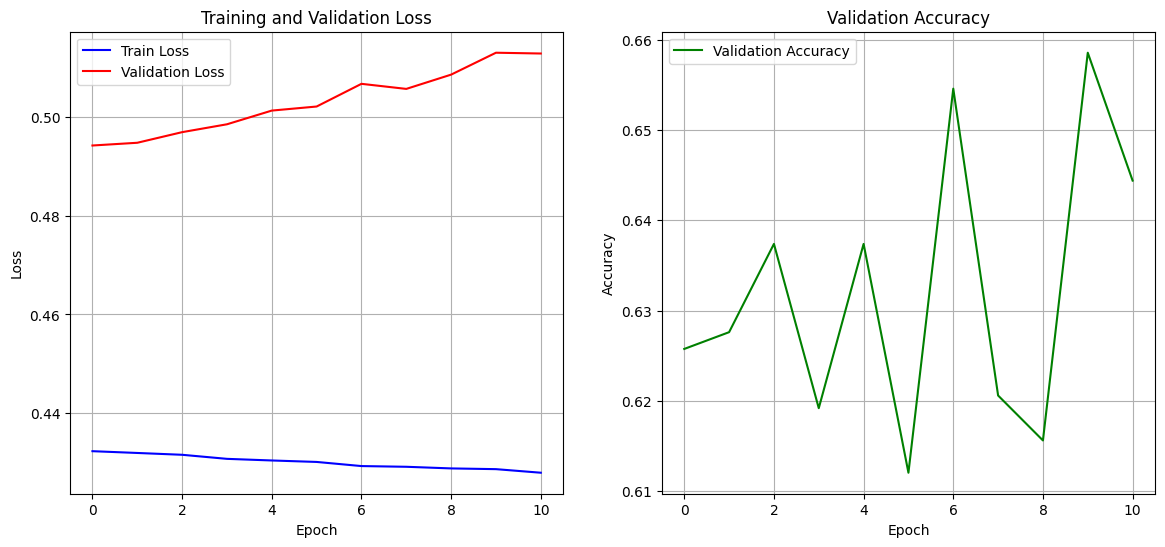

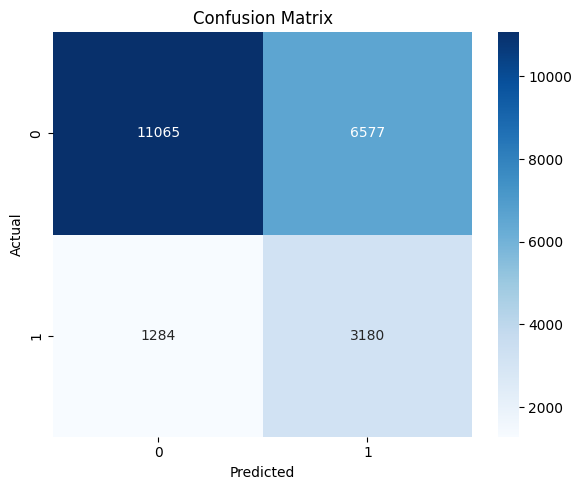


THRESHOLD OPTIMIZATION
Threshold | Precision | Recall | F1 Score
----------------------------------------
0.10      | 0.284     | 0.896  | 0.431
0.15      | 0.306     | 0.818  | 0.445
0.20      | 0.326     | 0.712  | 0.447
0.25      | 0.348     | 0.585  | 0.436
0.30      | 0.371     | 0.441  | 0.403
0.35      | 0.394     | 0.304  | 0.343
0.40      | 0.419     | 0.196  | 0.267
0.45      | 0.454     | 0.115  | 0.184
0.50      | 0.489     | 0.062  | 0.110
0.55      | 0.520     | 0.032  | 0.060
0.60      | 0.615     | 0.016  | 0.031
0.65      | 0.614     | 0.008  | 0.015
0.70      | 0.636     | 0.005  | 0.009
0.75      | 0.765     | 0.003  | 0.006
0.80      | 0.900     | 0.002  | 0.004
0.85      | 0.800     | 0.001  | 0.002

Best threshold: 0.20 with F1 score: 0.4472


In [30]:
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

start=time.time()

for epoch in range(11):
    train_loss = train_epoch(torch_model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1, _, _,_ = validate_epoch(torch_model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    if epoch % 10 == 0 :
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
              f"Val F1: {val_f1:.4f}" )

end=time.time()
print("Time taken : "+str(end-start))

print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

_, accuracy, f1, all_preds, all_labels,all_probs = validate_epoch(torch_model, test_loader, criterion)

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
PR_AUC=average_precision_score(all_labels,all_probs)

print(f"Final Test Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"PR-AUC:    {PR_AUC:.4f}")


print(f"\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(val_accuracies, label='Validation Accuracy', color='green')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

cm = confusion_matrix(all_labels, all_preds )

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Try different thresholds to optimize F1 score
print("\n" + "="*50)
print("THRESHOLD OPTIMIZATION")
print("="*50)

torch_model.eval()
all_probs = []
all_true_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = torch_model(batch_X)
        probs = torch.sigmoid(output).view(-1)
        all_probs.extend(probs.cpu().numpy())
        all_true_labels.extend(batch_y.view(-1).cpu().numpy())

thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.2
best_f1_thresh = 0

print("Threshold | Precision | Recall | F1 Score")
print("-" * 40)

for threshold in thresholds:
    preds = (np.array(all_probs) > threshold).astype(int)

    if len(np.unique(preds)) > 1:
        precision_t = precision_score(all_true_labels, preds)
        recall_t = recall_score(all_true_labels, preds)
        f1_t = f1_score(all_true_labels, preds)

        print(f"{threshold:.2f}      | {precision_t:.3f}     | {recall_t:.3f}  | {f1_t:.3f}")

        if f1_t > best_f1_thresh:
            best_f1_thresh = f1_t
            best_threshold = threshold

print(f"\nBest threshold: {best_threshold:.2f} with F1 score: {best_f1_thresh:.4f}")
